![imagen con dos cerebros enfrentados, el de la izquierda azul y el de la derecha naranja de los que salen ramificaciones](../img/img_cabecera.PNG)

# Análisis y visualizaciones de los datos transformados sobre el comportamiento de personas introvertidas y extrovertidas

Existen dos notebooks previos a este donde se pueden ver los trabajos de [exploración](exploracion.ipynb) y [transformación](transformacion.ipynb) de los datos.

El último paso de este trabajo se centra en el análisis de los datos y la visualización de las conclusiones obtenidas.
El análisis se ha dividido en función del número de variables a analizar de forma conjunta. Además se han propuesto una serie de preguntas que se irán respondiendo en cada apartado.

La estructura a seguir es la siguiente:
- [0. Importación de librerías y carga de datos](#0-importación-de-librerías-y-carga-de-datos)
- [1. Análisis univariante](#1-análisis-univariante)
- [2. Análisis bivariante](#2-análisis-bivariante)
- [3. Análisis multivariante](#3-análisis-multivariante)


### 0. Importación de librerías y carga de datos

In [1]:
# Librerias necesarias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")

import src.transformaciones as tr
import src.visualizaciones as vs

from scipy.stats import ttest_ind, chi2_contingency

Funciones ejecutadas correctamente


In [2]:
# Carga del csv:
df = pd.read_csv('../data/data_transformed_no_nul.csv')

In [3]:
df.shape

(2477, 8)

Antes de comenzar con los análisis y las visualizaciones clasificaremos de nuevo nuestras variables.

In [4]:
target, numericas, categoricas = tr.clasificador_variables(df, 'personality')

print(f'Columna objetivo: {target}')
print(f'Columnas numéricas: {numericas}')
print(f'Columnas categóricas: {categoricas}')

Columna objetivo: personality
Columnas numéricas: ['time_spent_alone', 'social_event_attendance', 'going_outside', 'friends_circle_size', 'post_frequency']
Columnas categóricas: ['stage_fear', 'drained_after_socializing']


### 1. Análisis univariante

En este apartado se analizarán las variables de forma individual para contestar a las siguientes preguntas:
- ¿Está equilibrado el dataset en base a su columna objetivo?
- ¿Cómo se distribuyen las variables categóricas?
- Las variables numéricas, ¿siguen una distribución normal?
- ¿Existen valores atípicos en el número de amigos?

El primer paso para analizar nuestro dataset es ver si nuestra columna objetivo está balanceada o no. En este caso se observa que los valores recogidos son muy similares, siendo ligeramente mayores los pertenecientes al grupo de extrovertidos.

In [5]:
df.personality.value_counts(normalize = True)

personality
extrovert    0.514332
introvert    0.485668
Name: proportion, dtype: float64

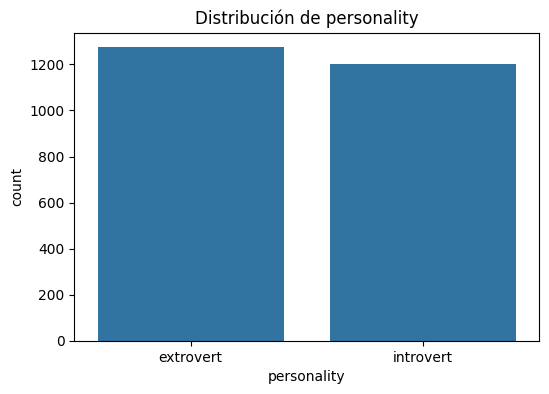

In [6]:
vs.pintar_grafico_barras_uni(df,[target])

En cuanto a las variables categóricas obtenemos conclusiones muy similares, ya que como vimos con anterioridad estaban fuertemente correlacionadas. Ambas presentan distribuciones similares, por lo que volvemos a tener un dataset balanceado en ambas características.

In [7]:
df['stage_fear'].value_counts(normalize = True)

stage_fear
no     0.501009
yes    0.498991
Name: proportion, dtype: float64

In [8]:
df['drained_after_socializing'].value_counts(normalize = True)

drained_after_socializing
no     0.501009
yes    0.498991
Name: proportion, dtype: float64

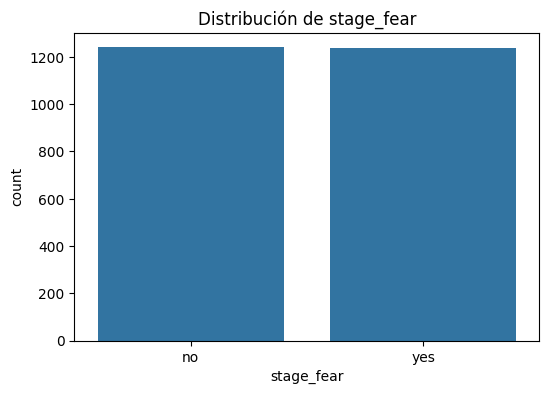

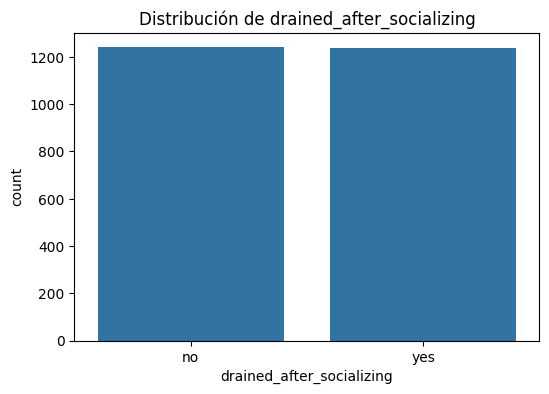

In [9]:
vs.pintar_grafico_barras_uni(df,categoricas)

En cuanto a la distribución de las columnas numéricas ninguna sigue una distribución normal. Por lo que si a futuro queremos aplicar modelos predictivos dberíamos normalizar estos datos.

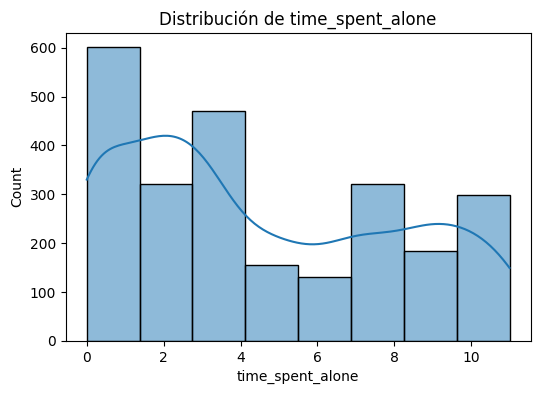

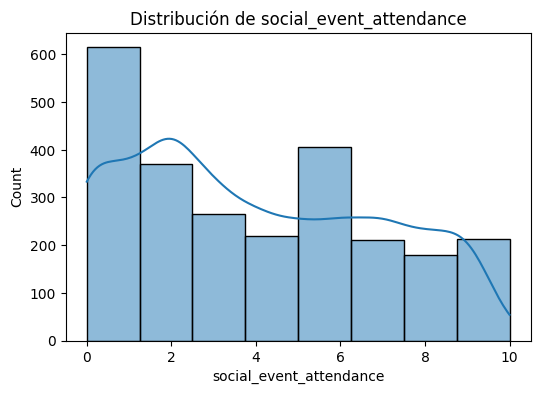

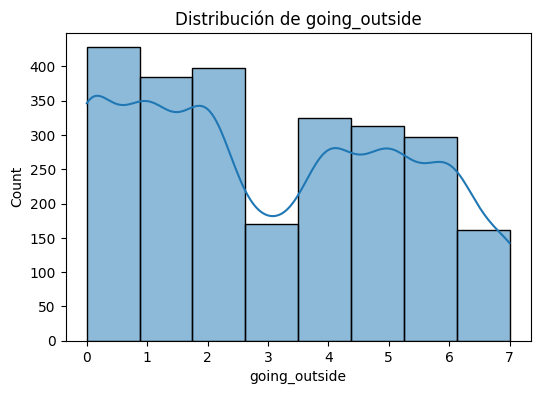

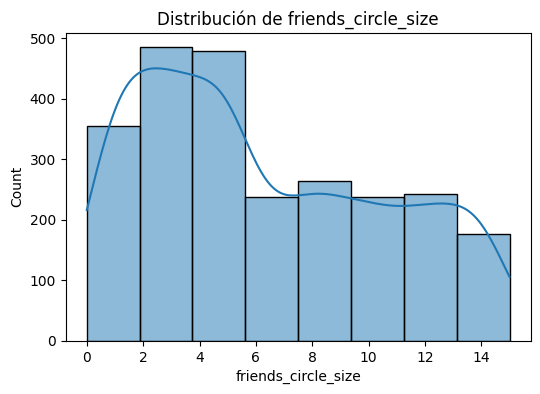

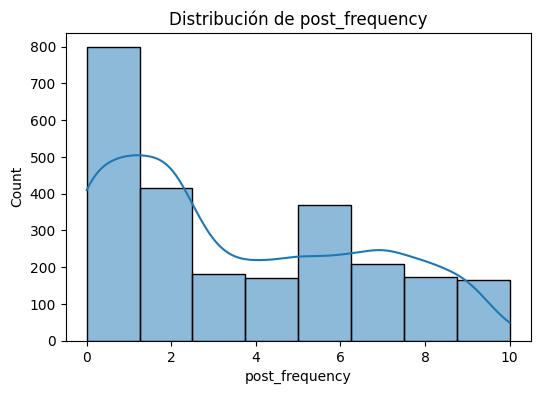

In [10]:
vs.pintar_distrib_num_uni(df,numericas)

### 2. Análisis bivariante

Aquí se analizarán pares de variables para ver su comportamiento en base a otra variable. Las preguntas que se van a responder serán:
- Las personas introvertidas ¿tienen pánico escénico?
- ¿Las personas que más publican en redes sociales son extrovertios o introvertidos? ¿Existen datos atípicos?
- ¿Cuantos amigos tienen las personas que se sienten agotadas después de socializar? ¿Y las que no? 
- ¿Existe alguna relación entre tiempo que pasan a solas y el número de amigos?
- ¿Cuáles son las variables que explican mejor la variable objetivo?

En cuanto a la respuesta a la primera pregunta podríamos decir que sí, ya que el 94% de las personas introvertidas poseen este aspecto.

In [11]:
df.groupby('personality')['stage_fear'].value_counts(normalize=True)

personality  stage_fear
extrovert    no            0.914443
             yes           0.085557
introvert    yes           0.936825
             no            0.063175
Name: proportion, dtype: float64

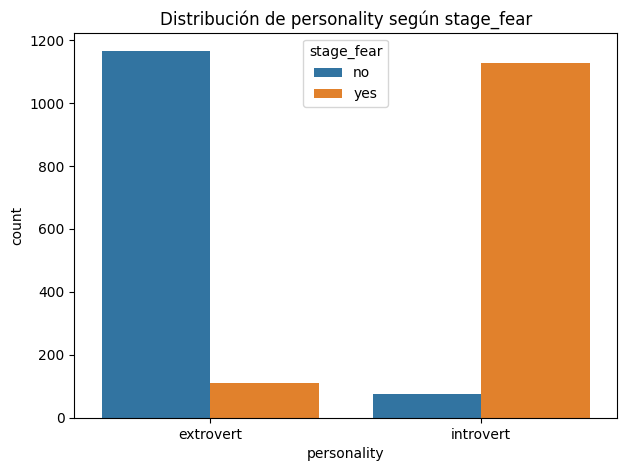

In [12]:
vs.grafico_barras_categoricas_target(df,['stage_fear'],target)

Se observa que la mediana de las publicaciones en redes sociales de las personas introvertidas está en torno a 1, mientras que las extrovertidas es sobre 6. Por lo tanto, las personas extrovertidas tienden a publicar más que las introvertidas. Sin embatrgo, dentro del grupo de introvertidos existen valres atípicos que indican que hay personas que publican de forma más activa lo que refleja una variabilidad de comportamiento para personas con este rasgo de personalidad.

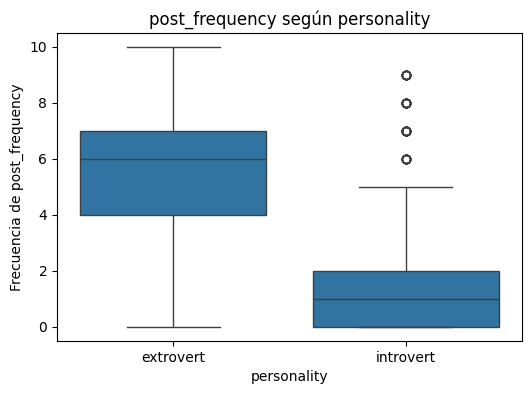

In [13]:
vs.dibujar_boxplot(df,'personality',['post_frequency'])

De media, las personas que se sienten agotadas después de socializar tienen 3 amigos mientras que aquellos que no llegan hasta los 10 amigos.

In [14]:
(df.groupby('drained_after_socializing')['friends_circle_size'].mean()).round()

drained_after_socializing
no     10.0
yes     3.0
Name: friends_circle_size, dtype: float64

Existe una correlación negativa entre el tiempo que se pasa a solas y la cantidad de amigos que se tiene. Esto significa que a más amigos menos tiempo a solas pasan. Además, podemos acotar que las personas que tienen 5 amigos o menos pasan solos entre 4 y 11 horas mientras que aquellos que poseen más de 5 su tiempo en solitario es mucho menor, menos de 3 horas.

In [15]:
df[['time_spent_alone', 'friends_circle_size']].corr()

,time_spent_alone,friends_circle_size
time_spent_alone,1.000000,-0.717649
friends_circle_size,-0.717649,1.000000


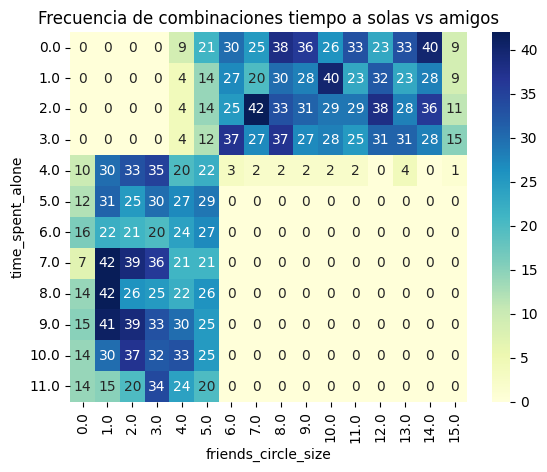

In [16]:
tabla = pd.crosstab(df['time_spent_alone'], df['friends_circle_size'])
sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Frecuencia de combinaciones tiempo a solas vs amigos')
plt.show()

Para identificar qué variables explican mejour la variable objetivo debemos dividirlo entre categóricas y numéricas ya que cada una requiere un análisis diferente.

En el caso de las numéricas se ha optado por el cálculo del p-value mediante t-test y su representación mediante boxplots. Los resultados obtenidos del p-value en todas las variables son próximos a 0. Al ser un valor inferior a 0.05 significa que todas ellas son significativas a la hora de explicar la personalidad. Por otro lado, al representar los diagramas de caja se observa un comportamiento peculiar, mayormente en el grupo de introvertidos ya que presentan valores atípicos menos en el tiempo que pasan a solas. Esto implica que dentro de este grupo hay mucha variabilidad. Sin embargo, el grupo de extrovertidos solo presenta outliers en el tiempo que pasan solos lo cual es lógico porque al ser una investigación hecha a estudiantes lo normal es que pasen más tiempo a solas para dedicarlo a sus tareas lectivas.

En cuanto a las categóricas se han usado tablas de contingencia, gráficos de barras y se ha complementado con la prueba del chi-cuadrado. Al igual que con las numéricas, al obtener el p-value ambas variables presentan un valor de 0 lo que significa que se rechaza la hipótesis nula y por tanto ambas, son variables signifiativas. Además en los gráficos podemos ver como son distribuciones completamente opuestas para introvertidos y extrovertidos, lo cual confirma más que estas variables son significativas.

Por tanto, en este dataset todas las variables están relacionadas con la variable *personality*.

In [17]:
vs.obtener_p_value (df,target,'introvert','extrovert',numericas)

P-value de time_spent_alone = 0.0
P-value de social_event_attendance = 0.0
P-value de going_outside = 0.0
P-value de friends_circle_size = 0.0
P-value de post_frequency = 0.0


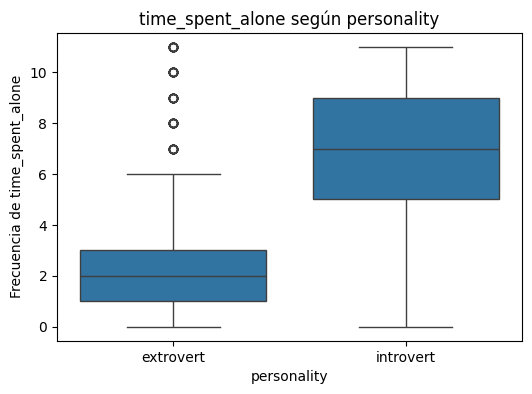

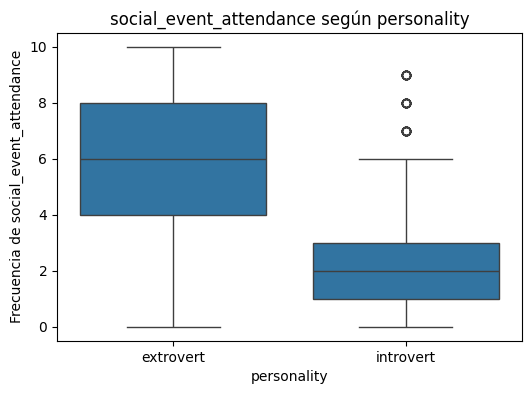

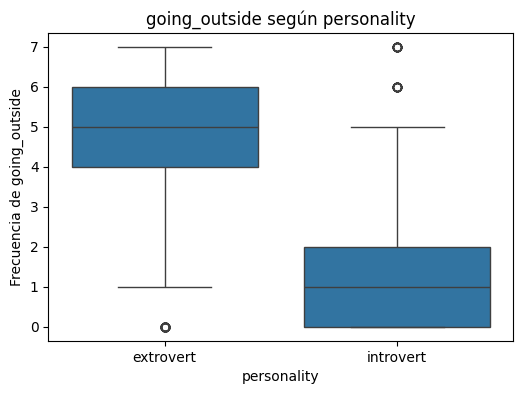

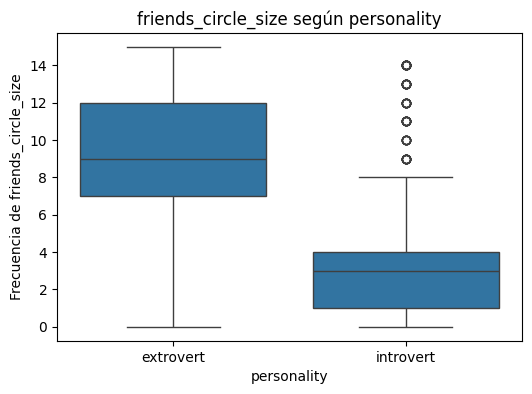

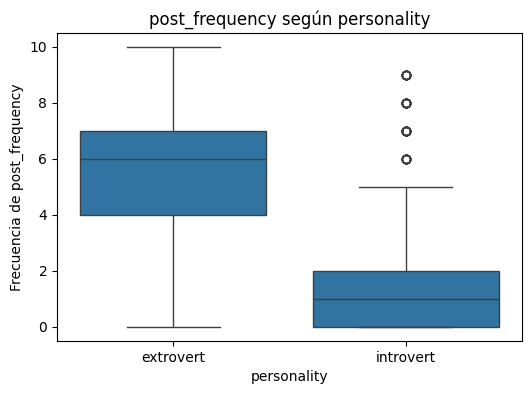

In [18]:
vs.dibujar_boxplot(df,target,numericas)

In [19]:
vs.calculo_tabla_contingencia_chi2(df,target,categoricas)

stage_fear     no   yes
personality            
extrovert    1165   109
introvert      76  1127

P-value de stage_fear = 0.0
--------------------------
drained_after_socializing    no   yes
personality                          
extrovert                  1165   109
introvert                    76  1127

P-value de drained_after_socializing = 0.0
--------------------------


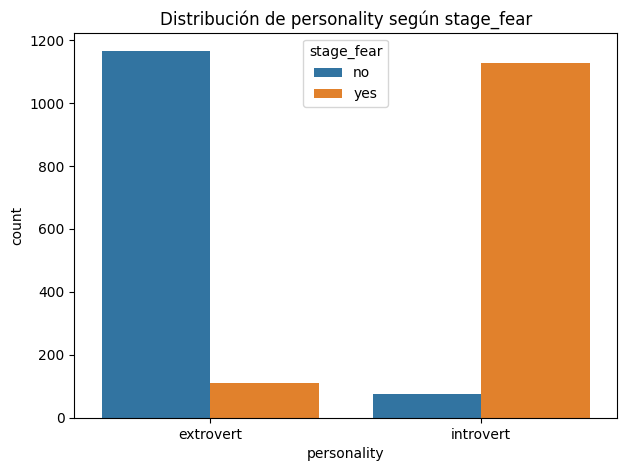

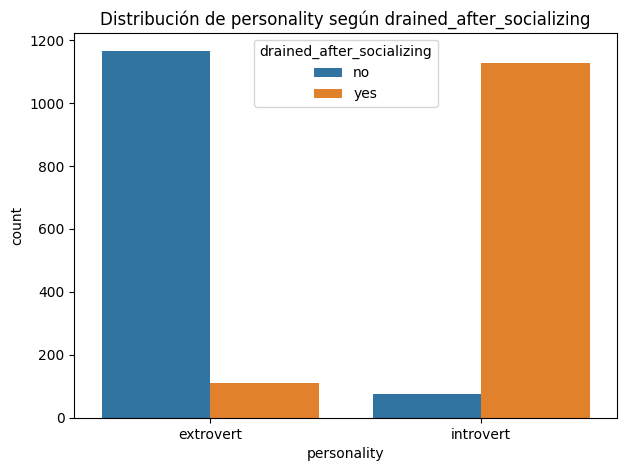

In [20]:
vs.grafico_barras_categoricas_target(df,categoricas,target)

### 3. Análisis multivariante

Por último, el análisis multivariante muestra 
Las preguntas a contestar son:
- ¿Existe algún perfil multivariante, dentro de las variables numéricas, que defina la personalidad de un individuo?
- ¿Cómo se relacionan simultaneamente el tiempo a solas, el número de amigos y la frecuencia de publicaciones?

Para contestar a la primera pregunta se ha realizado tanto un gráfico de barras con las medias de cada grupo de personalidad para las variables numéricas y un pairplot. 
Con ellas observamos diferencias visuales entre grupos pero no se tratan de grupos definidos ya que se debe a que son variables numéricas discretas. Por lo tanto, sí que se pueden ver rasgos representativos de cada personalidad pero no se puede afirmar la existencia de un único perfil multivariante que defina la personalidad.

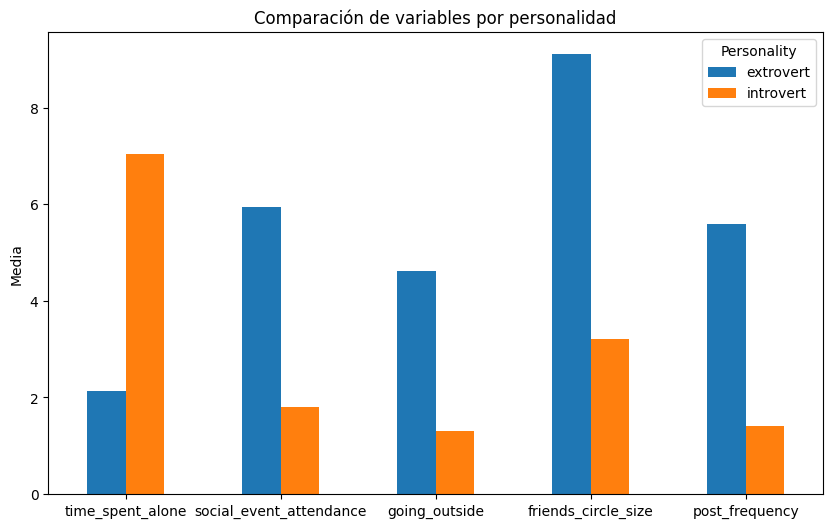

In [21]:
mean_profiles = df.groupby("personality")[numericas].mean().T

mean_profiles.plot(kind="bar", figsize=(10,6))
plt.title("Comparación de variables por personalidad")
plt.ylabel("Media")
plt.xticks(rotation=0)
plt.legend(title="Personality")
plt.show()

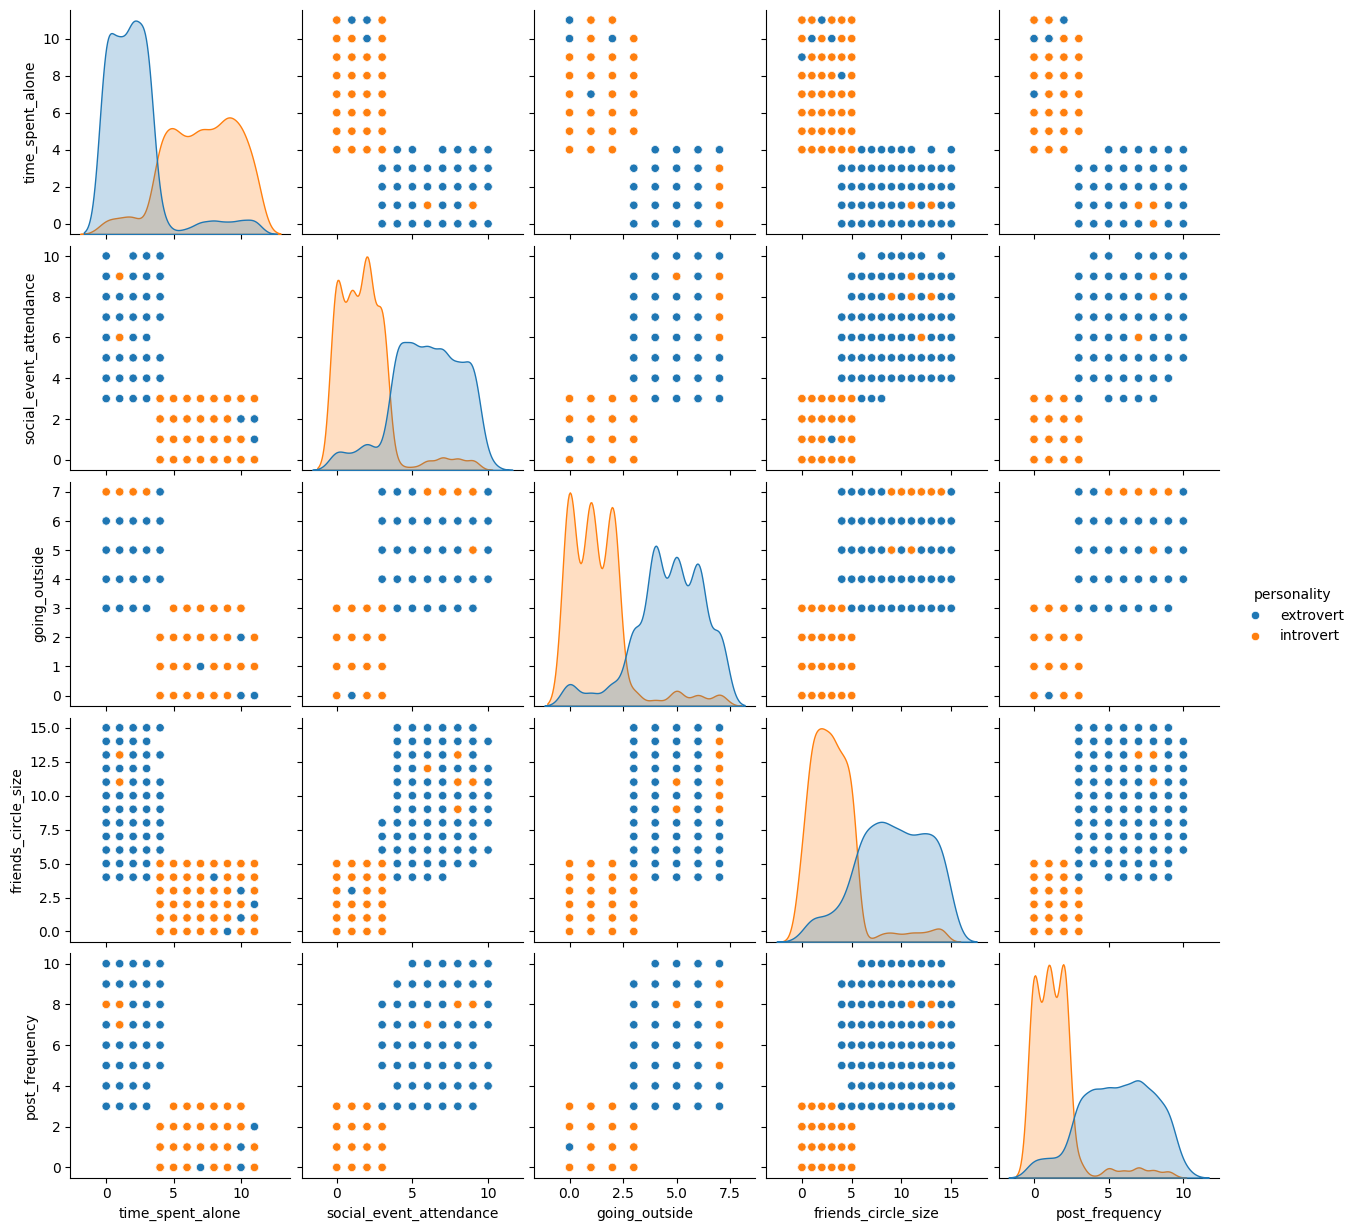

In [22]:
sns.pairplot(df, hue="personality", vars=numericas)
plt.show()

Para analizar como se relacionan simultaniamente las variables *"time_spent_alone", "friends_circle_size", "post_frequency"* se ha utilizado una matriz de correlacion para ver si existen relaciones positivas o negativas entre ellas.

El tiempo que pasa solo esta correlacionado negativamente con el circulo de amigos y la frecuencia de publicar en redes sociales, es decir que cuanto más tiempo pasa sola una persona menos amigos tiene y menos publica en redes sociales. Sin embargo, el círculo de amigos se relaciona  de forma negativa con el tiempo que pasa solo y de forma positiva con la frecuencia de publicaciones lo que implica que una persona con muchos amigos publica más que otra que tiene menos y pasa menos tiempo solo. Del mismo modo le sucede a una persona que genera muchas publicaciones, estas suelen tener más amigos y dedican menos tiempo para estar solas.

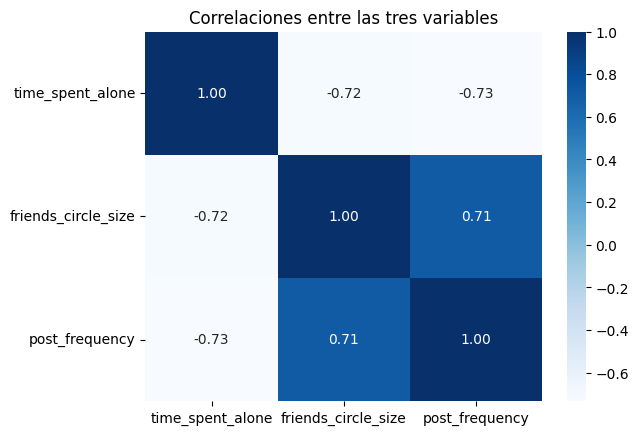

In [23]:
corr = df[["time_spent_alone", "friends_circle_size", "post_frequency"]].corr()

sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlaciones entre las tres variables")
plt.show()